In [15]:
import torch
import sys
import os.path as osp
import os
import sys
import numpy as np

sys.path.append("/eos/home-g/gkrzmanc/mlpf_data")
from src.dataset.dataset import SimpleIterDataset
from src.utils.utils import to_filelist
from torch.utils.data import DataLoader
#import dgl  # CPU only version for now
from tqdm import tqdm
from torch_scatter import scatter_sum
import matplotlib.pyplot as plt
import pickle
import numpy as np
import mplhep as hep


hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=13)

In [19]:
# This block is the same as 1_dataset.ipynb

datasets = {
    "train": "/eos/home-g/gkrzmanc/dataset_1408_CLIC_more_particles_DS.root",
    "test": "/eos/home-g/gkrzmanc/testing_ds_29082023.root"
}

class Args:
    def __init__(self, datasets):
        self.data_train = [datasets]
        self.data_val = [datasets]
        #self.data_train = files_train
        self.data_config = '/eos/home-g/gkrzmanc/mlpf_data/config_files/config_2_newlinks.yaml'
        self.extra_selection = None
        self.train_val_split = 0.8
        self.data_fraction = 1
        self.file_fraction = 1
        self.fetch_by_files = False
        self.fetch_step = 0.01
        self.steps_per_epoch = None
        self.in_memory = False
        self.local_rank = None
        self.copy_inputs = False
        self.no_remake_weights = False
        self.batch_size = 10
        self.num_workers = 0
        self.demo = False
        self.laplace = False
        self.diffs = False
        self.class_edges = False


args = {key: Args(value) for key, value in datasets.items()}

datas = {}
files_dict = {}
for key in datasets:
    train_range = (0, args[key].train_val_split)
    train_file_dict, train_files = to_filelist(args[key], 'train')
    train_data = SimpleIterDataset(train_file_dict, args[key].data_config, for_training=True,
                                   extra_selection=args[key].extra_selection,
                                   remake_weights=True,
                                   load_range_and_fraction=(train_range, args[key].data_fraction),
                                   file_fraction=args[key].file_fraction,
                                   fetch_by_files=args[key].fetch_by_files,
                                   fetch_step=args[key].fetch_step,
                                   infinity_mode=False,
                                   in_memory=args[key].in_memory,
                                   async_load=False,
                                   name='train')
    datas[key] = train_data
    files_dict[key] = train_files

{'train': <__main__.Args object at 0x7f2cbea30970>, 'test': <__main__.Args object at 0x7f2cbea30880>}


In [25]:
iterators = {key: iter(val) for key, val in datas.items()}

from src.dataset.functions_graph import graph_batch_func

train_loaders = {key: DataLoader(train_data, batch_size=1, drop_last=True, pin_memory=True,
                          num_workers=min(args[key].num_workers, int(len(train_files) * args[key].file_fraction)),
                          collate_fn=graph_batch_func,
                          persistent_workers=args[key].num_workers > 0 and args[key].steps_per_epoch is not None) for key in args}

iterators = {key: iter(item) for key,item in train_loaders.items()}

=== Restarting DataIter train, seed=None ===
=== Restarting DataIter train, seed=None ===
=== Restarting DataIter train, seed=None ===
=== Restarting DataIter train, seed=None ===


In [26]:
iterators.keys()

dict_keys(['train', 'test'])

In [27]:
from torch_scatter import scatter_sum
def get_ratios(g, y, corr_w_mass=False, return_pid_dict=False):
    part_idx = g.ndata["particle_number"]
    true_idx = np.arange(len(part_idx))
    part_idx = part_idx[true_idx]
    hit_types = g.ndata["hit_type"][true_idx]
    hit_idx = torch.where((hit_types[:, 2] == 1) | (hit_types[:, 3] == 1))[0]
    track_idx = torch.where((hit_types[:, 0] == 1) | (hit_types[:, 1] == 1))[0]
    hit_energies = g.ndata["e_hits"].flatten()[true_idx]  #[hit_idx]
    where_e_zero = hit_energies == 0
    hit_momenta = g.ndata["p_hits"].flatten()[true_idx]#[track_idx]
    energy_from_showers = scatter_sum(hit_energies, part_idx.long(), dim=0)
    y_energy = y[:, 3]
    y_pid = y[:, -1].to(torch.long)
    energy_from_showers = energy_from_showers[1:]
    assert len(energy_from_showers) > 0
    if return_pid_dict:
        pids = y_pid.unique().long()
        pid_dict = {int(pid): (energy_from_showers[y_pid == pid] / y_energy[y_pid == pid]).tolist() for pid in pids}
        pid_dict["ALL"] = (energy_from_showers / y_energy).tolist()
        return pid_dict
    return (energy_from_showers / y_energy).tolist()


In [29]:
#all_ratios = {}
num_particles = {}
num_hits = {}
particle_energy = {}
hits_energy_ecal = {}
hits_energy_hcal = {}


def upd_dict(d, small_dict):
    for k in small_dict:
        if k not in d:
            d[k] = []
        d[k] += small_dict[k]
    return d

for i in tqdm(range(100)):
    for key in iterators:
        g, y = next(iterators[key])
        num_part = y.shape[0]
        if key not in num_particles:
            num_particles[key] = []
            num_hits[key] = []
            particle_energy[key] = []
            hits_energy_ecal[key] = []
            hits_energy_hcal[key] = []
        num_particles[key].append(num_part)
        num_hits[key].append(g.ndata["particle_number"].shape[0])
        particle_energy[key] += y[:, 3].tolist()
        hits_energy = g.ndata["e_hits"].flatten().tolist()
        ecal_hits_filter = (g.ndata["hit_type"][:, 2] == 1) | (g.ndata["hit_type"][:, 3] == 1)
        hits_energy_ecal[key] += np.array(hits_energy)[ecal_hits_filter].tolist()
        hits_energy_hcal[key] += np.array(hits_energy)[~ecal_hits_filter].tolist()

        #ratios = get_ratios(g, y, corr_w_mass=True, return_pid_dict=True)
        #all_ratios = upd_dict(all_ratios, ratios)
        #TODOs tmrw: check particle number dist., how many are we throwing away




100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


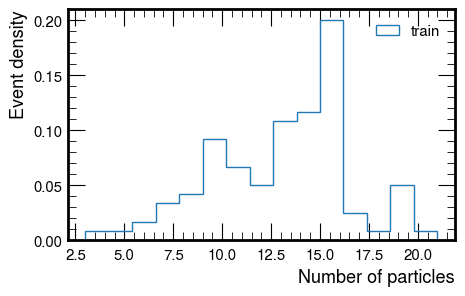

In [32]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.set_xlabel("Number of particles")
for key in num_particles:
    if key == "test": continue
    ax.hist(num_particles[key], bins=15, density=True, label=key, histtype="step")
ax.set_ylabel("Event density")
ax.legend()
fig.show()

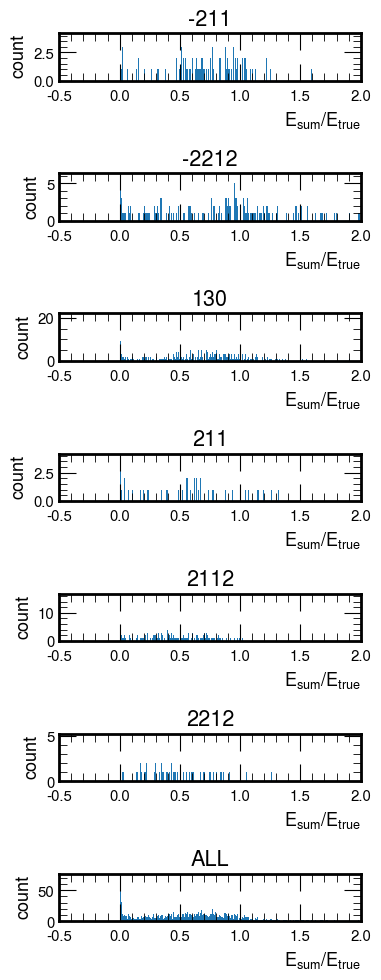

In [16]:
import matplotlib.pyplot as plt
all_ratios = {str(k): v for k, v in all_ratios.items()}
keys = sorted(list(all_ratios.keys()))
fig, ax = plt.subplots(len(keys), figsize=(5, 13))

for i in range(len(keys)):
    ax[i].hist(all_ratios[keys[i]], bins=400)
    ax[i].set_xlim(-0.5, 2)
    ax[i].set_ylabel("count")
    ax[i].set_xlabel(r"$E_{sum}/E_{true}$")
    ax[i].set_title(f"{keys[i]}")

fig.tight_layout()

#fig.savefig("/eos/home-g/gkrzmanc/PF_reports/initial_histograms/new_dataset/energy_hist_corr1.pdf")
fig.show()

In [8]:
#import pickle
#pickle.dump(all_ratios, open("/eos/home-g/gkrzmanc/PF_reports/initial_histograms/corr_ds/PID_filtered_energy_sum_vs_true.pkl", "wb"))

FileNotFoundError: [Errno 2] No such file or directory: '/eos/home-g/gkrzmanc/PF_reports/initial_histograms/corr_ds/PID_filtered_energy_sum_vs_true.pkl'